In [ ]:
# %pip install opencv-python numpy scikit-learn tensorflow keras matplotlib

# Đọc data

In [10]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


# B1: Đọc vào full mọi ảnh từ đường dẫn
def load_images_from_folder(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_path = os.path.join(folder, label)
        if os.path.isdir(label_path):
            for filename in os.listdir(label_path):
                img_path = os.path.join(label_path, filename)
                if img_path.endswith(".jpg") or img_path.endswith(".png"):
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, (224, 224))
                    if img is not None:
                        images.append(img)
                        labels.append(label)
    return images, labels


folder_path = "/mnt/DataK/Project/ThyroidCancer/data/origin_data/B256"
images, labels = load_images_from_folder(folder_path)

# B2: Cân bằng lại số lượng ảnh của từng nhãn (không cần thiết - do đây là mất cân bằng bản chất)
# Tính số lượng ảnh của từng nhãn
label_counts = {}
for label in labels:
    label_counts[label] = label_counts.get(label, 0) + 1
print(f"Số lượng ảnh từng nhãn: {label_counts}")

# Xác định số lượng ảnh tối đa của mỗi nhãn
max_count = max(label_counts.values())
print(f"Số ảnh có nhiều nhất ở 1 nhãn: {max_count}")


# B3: Phân chia train:valid:test theo tỷ lệ 65:25:10
X_train, X_temp, y_train, y_temp = train_test_split(
    images, labels, test_size=0.35, random_state=42
    # balanced_images, balanced_labels, test_size=0.35, random_state=42
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.1, random_state=42
)

Số lượng ảnh từng nhãn: {'B2': 103, 'B5': 541, 'B6': 777}
Số ảnh có nhiều nhất ở 1 nhãn: 777


In [11]:
# Chuyển đổi danh sách X_train thành mảng NumPy
X_train = np.array(X_train)
X_valid = np.array(X_valid)
X_test = np.array(X_test)

from tensorflow.keras.utils import to_categorical

# y_train = np.array(y_train)
# y_valid = np.array(y_valid)
# y_test = np.array(y_test)
# Chuyển đổi nhãn sang dạng one-hot
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Chuyển đổi nhãn từ dạng chuỗi sang dạng số nguyên
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_valid_encoded = label_encoder.fit_transform(y_valid)
y_test_encoded = label_encoder.fit_transform(y_test)

# Mã hóa one-hot cho các nhãn
num_classes = len(label_encoder.classes_)
y_train_one_hot = to_categorical(y_train_encoded, num_classes=num_classes)
y_valid_one_hot = to_categorical(y_valid_encoded, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test_encoded, num_classes=num_classes)

# Load vào Model

In [12]:
# Tensorflow Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import (
    Callback,
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
)
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

# # Data Augmentation Step
# augment = tf.keras.Sequential(
#     [
#         layers.Resizing(224, 224),
#         layers.Rescaling(1.0 / 255),
#         layers.RandomFlip("horizontal"),
#         layers.RandomRotation(0.1),
#         layers.RandomZoom(0.1),
#         layers.RandomContrast(0.1),
#     ]
# )


# # Load the pretained model
# pretrained_model = tf.keras.applications.efficientnet.EfficientNetB7(
#     input_shape=(224, 224, 3), include_top=False, weights="imagenet", pooling="max"
# )

# pretrained_model.trainable = False

In [5]:
from keras.models import Model
from keras.layers import Dense, Dropout, BatchNormalization

# Tạo kiến trúc mô hình
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)

outputs = Dense(3, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

# Xem kiến trúc mô hình
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling_1[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_2[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,728 │ stem_conv_pad[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        256 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        576 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        256 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 64)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 64)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 16)  │      1,040 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 64)  │      1,088 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 64)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      2,048 │ block1a_se_excit

 Total params: 64,460,826 (245.90 MB)

 Trainable params: 362,371 (1.38 MB)

 Non-trainable params: 64,098,455 (244.52 MB)

In [13]:
# Create checkpoint callback
checkpoint_path = "animals_classification_model_checkpoint.weights.h5"
checkpoint_callback = ModelCheckpoint(
    checkpoint_path, save_weights_only=True, monitor="val_accuracy", save_best_only=True
)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(
    monitor="val_loss",  # watch the val loss metric
    patience=5,
    restore_best_weights=True,
)  # if val loss decreases for 3 epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6)

In [22]:
# Compile lại mô hình
model.compile(optimizer=Adam(0.00001), loss="categorical_crossentropy", metrics=["accuracy"])

# Tải trọng số vào mô hình
model.load_weights("model_checkpoint.weights.h5")   # đây là kết quả của 10 epoch đầu tiên 

# Đánh giá mô hình trên dữ liệu validation
loss, accuracy = model.evaluate(X_test, y_test_one_hot)
print("Test Accuracy:", accuracy)


/home/harito/venv/ai_env_3.11/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2/2 ━━━━━━━━━━━━━━━━━━━━ 56s 11s/step - accuracy: 0.3783 - loss: 1.0636
Validation Accuracy: 0.3799999952316284


# Train model

## 10 epoch đầu tiên

In [7]:
# model.compile(
#     optimizer=Adam(0.00001), loss="categorical_crossentropy", metrics=["accuracy"]
# )

history = model.fit(
    X_train,
    y_train_one_hot,
    # epochs=20,
    validation_data=(X_valid, y_valid_one_hot),
    epochs=10,
    callbacks=[
        early_stopping,
        checkpoint_callback,
        reduce_lr,
    ],
)

Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 800s 25s/step - accuracy: 0.2826 - loss: 1.9942 - val_accuracy: 0.0893 - val_loss: 1.7166 - learning_rate: 1.0000e-05
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 699s 24s/step - accuracy: 0.3148 - loss: 1.8914 - val_accuracy: 0.1540 - val_loss: 1.4265 - learning_rate: 1.0000e-05
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 743s 26s/step - accuracy: 0.3842 - loss: 1.6097 - val_accuracy: 0.2210 - val_loss: 1.3308 - learning_rate: 1.0000e-05
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 713s 25s/step - accuracy: 0.3503 - loss: 1.6120 - val_accuracy: 0.3683 - val_loss: 1.2155 - learning_rate: 1.0000e-05
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 732s 25s/step - accuracy: 0.3676 - loss: 1.5803 - val_accuracy: 0.4241 - val_loss: 1.1494 - learning_rate: 1.0000e-05
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 741s 25s/step - accuracy: 0.3739 - loss: 1.6677 - val_accuracy: 0.4665 - val_loss: 1.1322 - learning_rate: 1.0000e-05
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 742s 26s/step - accuracy: 

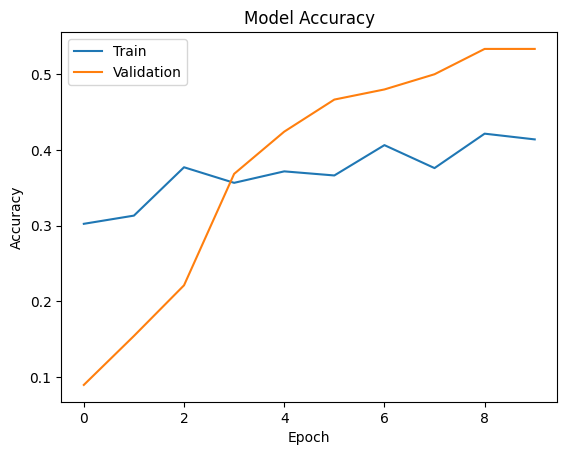

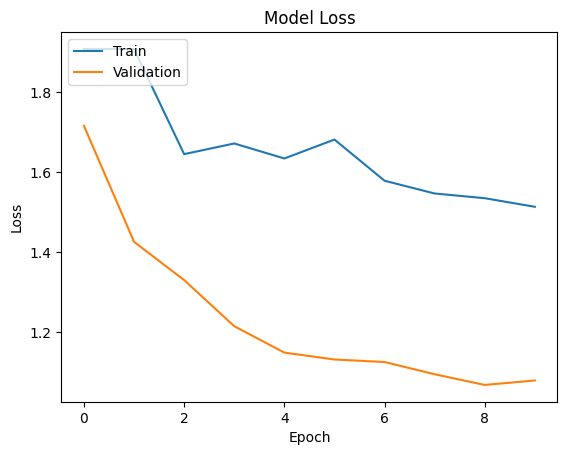

In [8]:
import matplotlib.pyplot as plt

# Lấy lịch sử từ quá trình đào tạo
training_history = history.history

# Vẽ biểu đồ sự thay đổi của accuracy qua các epoch
plt.plot(training_history['accuracy'])
plt.plot(training_history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Vẽ biểu đồ sự thay đổi của loss function qua các epoch
plt.plot(training_history['loss'])
plt.plot(training_history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## 2 epoch tiếp theo

In [9]:
history = model.fit(
    X_train,
    y_train_one_hot,
    # epochs=20,
    validation_data=(X_valid, y_valid_one_hot),
    epochs=2,
    callbacks=[
        early_stopping,
        checkpoint_callback,
        reduce_lr,
    ],
)

Epoch 1/2
29/29 ━━━━━━━━━━━━━━━━━━━━ 692s 24s/step - accuracy: 0.4245 - loss: 1.5078 - val_accuracy: 0.5469 - val_loss: 1.0514 - learning_rate: 1.0000e-05
Epoch 2/2
29/29 ━━━━━━━━━━━━━━━━━━━━ 736s 26s/step - accuracy: 0.4292 - loss: 1.4806 - val_accuracy: 0.5580 - val_loss: 1.0259 - learning_rate: 1.0000e-05


# 10 epoch tiếp theo

In [23]:
history = model.fit(
    X_train,
    y_train_one_hot,
    # epochs=20,
    validation_data=(X_valid, y_valid_one_hot),
    epochs=10,
    callbacks=[
        early_stopping,
        checkpoint_callback,
        reduce_lr,
    ],
)

Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 809s 25s/step - accuracy: 0.3600 - loss: 1.6704 - val_accuracy: 0.5268 - val_loss: 1.0151 - learning_rate: 1.0000e-05
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 621s 22s/step - accuracy: 0.4120 - loss: 1.5582 - val_accuracy: 0.4978 - val_loss: 1.0512 - learning_rate: 1.0000e-05
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 692s 24s/step - accuracy: 0.4400 - loss: 1.5390 - val_accuracy: 0.5022 - val_loss: 1.0548 - learning_rate: 1.0000e-05
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 662s 23s/step - accuracy: 0.4061 - loss: 1.5040 - val_accuracy: 0.5179 - val_loss: 1.0332 - learning_rate: 1.0000e-05
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 647s 22s/step - accuracy: 0.4171 - loss: 1.5419 - val_accuracy: 0.5134 - val_loss: 1.0410 - learning_rate: 2.0000e-06
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 564s 20s/step - accuracy: 0.4359 - loss: 1.4255 - val_accuracy: 0.5134 - val_loss: 1.0454 - learning_rate: 2.0000e-06


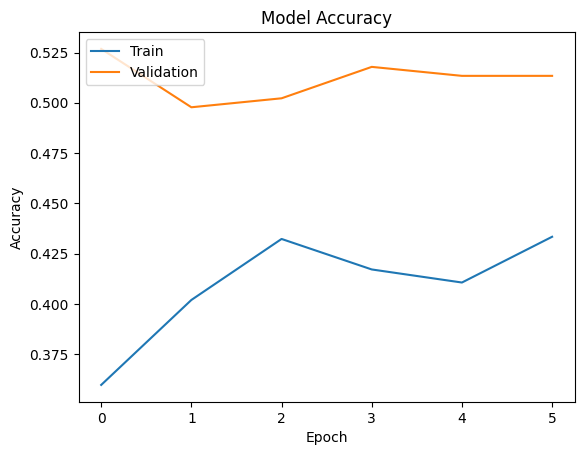

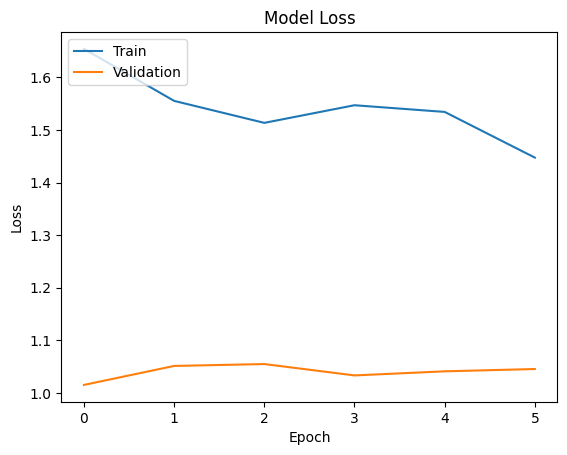

In [24]:
import matplotlib.pyplot as plt

# Lấy lịch sử từ quá trình đào tạo
training_history = history.history

# Vẽ biểu đồ sự thay đổi của accuracy qua các epoch
plt.plot(training_history['accuracy'])
plt.plot(training_history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Vẽ biểu đồ sự thay đổi của loss function qua các epoch
plt.plot(training_history['loss'])
plt.plot(training_history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [25]:
history = model.fit(
    X_train,
    y_train_one_hot,
    # epochs=20,
    validation_data=(X_valid, y_valid_one_hot),
    epochs=10,
    callbacks=[
        early_stopping,
        checkpoint_callback,
        # reduce_lr,
    ],
)

Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 651s 23s/step - accuracy: 0.4257 - loss: 1.5433 - val_accuracy: 0.5223 - val_loss: 1.0289
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 686s 24s/step - accuracy: 0.4117 - loss: 1.5193 - val_accuracy: 0.5112 - val_loss: 1.0394
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 679s 22s/step - accuracy: 0.4125 - loss: 1.5104 - val_accuracy: 0.5179 - val_loss: 1.0387
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 608s 21s/step - accuracy: 0.3893 - loss: 1.5972 - val_accuracy: 0.5089 - val_loss: 1.0551
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 672s 24s/step - accuracy: 0.3810 - loss: 1.5492 - val_accuracy: 0.5045 - val_loss: 1.0712


In [26]:
# Đánh giá mô hình trên dữ liệu validation
loss, accuracy = model.evaluate(X_test, y_test_one_hot)
print("Test Accuracy:", accuracy)

2/2 ━━━━━━━━━━━━━━━━━━━━ 25s 9s/step - accuracy: 0.4021 - loss: 1.0640
Test Accuracy: 0.4000000059604645
